<a href="https://colab.research.google.com/github/VilTea/Hist-Equalization/blob/main/Hist_Equalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 直方图均衡化(Histogram Equalization)的GPU实现

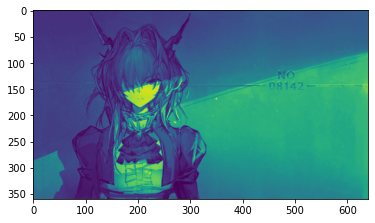

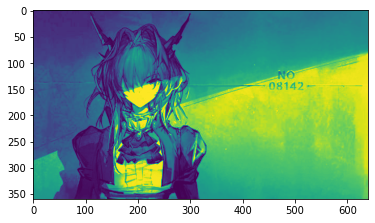

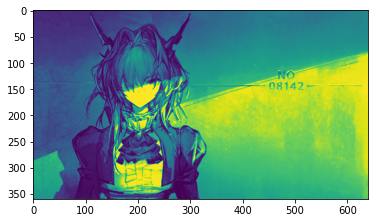

In [ ]:
import math
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda, float32
import os


threads_per_block = 512


@cuda.jit
def gpu_histogram_sta_kernel(img_size, img_gray, out):
    """
    统计直方图的gpu实现
    """
    idx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    if idx < img_size:
        # out[img_gray[row * img_w + col]] += 1
        cuda.atomic.add(out, img_gray[idx], 1)
        # cuda.atomic.add(test, idx, 1)


@cuda.jit
def gpu_probability_sta_kernel(img_size, hist, out):
    """
    概率直方图的gpu实现
    """
    idx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    if idx < 256:
      out[idx] = hist[idx] / img_size


@cuda.jit
def gpu_scan_probability_block_kernel(pb, rp, out):
    """
    概率前缀和的gpu实现
    """
    tmp = cuda.shared.array(shape=(threads_per_block), dtype=float32)
    tid = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x;
    if tid < 256:
        tmp[cuda.threadIdx.x] = float32(pb[tid]);
    i = 1
    while i <= cuda.threadIdx.x:
        cuda.syncthreads()
        tmp[cuda.threadIdx.x] += tmp[cuda.threadIdx.x - i]
        i *= 2
    out[tid] = tmp[cuda.threadIdx.x]
    if cuda.threadIdx.x == cuda.blockDim.x - 1:
        rp[cuda.blockIdx.x] = tmp[cuda.threadIdx.x]


@cuda.jit
def gpu_scan_probability_merge_kernel(out, rp):
    """
    概率前缀和的gpu实现，merge
    """
    tid = (cuda.blockIdx.x + 1) * cuda.blockDim.x + cuda.threadIdx.x
    if tid < 256:
        i = 0
        while i <= cuda.blockIdx.x:
            out[tid] += rp[i]
            i += 1


@cuda.jit
def gpu_equilibrium_kernel(pbc):
    """
    概率前缀和均衡化的gpu实现
    """
    idx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    if idx < 256:
        pbc[idx] = pbc[idx] * 255


@cuda.jit
def gpu_rewrite_image(img_size, img_gray, gray, out):
    """
    映射回原图像的gpu实现
    """
    idx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    if idx <= img_size:
        out[idx] = math.floor(gray[img_gray[idx]])


def main():
    img = cv.imread(os.getcwd() + '/test.jpg')   # BGR
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    eq = cv.equalizeHist(img_gray)
    img_gray = img_gray.astype(np.uint32)
    # img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_size = img_gray.size
    # img_size_f = float(img_size)
    w = img_gray.shape[0]
    h = img_gray.shape[1]
    img_gray = img_gray.flatten()

    blocks_per_grid = math.ceil(img_size / threads_per_block)
    # print(img_gray)
    # n = np.zeros(256, dtype=np.float64)
    # p = np.zeros(256, dtype=np.float64)
    # c = np.zeros(256, dtype=np.float64)
    img_device = cuda.to_device(img_gray) 
    # w_device = cuda.to_device(w)
    # h_device = cuda.to_device(h)
    n_device = cuda.to_device(np.zeros(256, dtype=np.float32))  # 频数
    p_device = cuda.device_array(256, dtype=np.float32)     # 概率
    c_device = cuda.device_array(256, dtype=np.float32)     # 前缀和
    # test_device = cuda.device_array(img_size)
    # img_size_device = cuda.to_device(img_size)
    out_device = cuda.device_array(img_size, dtype=np.uint32)   # 输出图像
    
    gpu_histogram_sta_kernel[blocks_per_grid, threads_per_block](img_size, img_device, n_device)
    cuda.synchronize()
    # n = n_device.copy_to_host()
    # print(n)
    gpu_probability_sta_kernel[blocks_per_grid, threads_per_block](img_size, n_device, p_device)
    cuda.synchronize()
    # p = p_device.copy_to_host()
    # print(p)
    rp_device = cuda.device_array(shape=(blocks_per_grid), dtype=np.int32)
    gpu_scan_probability_block_kernel[blocks_per_grid, threads_per_block](p_device, rp_device, c_device)
    cuda.synchronize()
    gpu_scan_probability_merge_kernel[blocks_per_grid, threads_per_block](rp_device, c_device)
    cuda.synchronize()
    gpu_equilibrium_kernel[blocks_per_grid, threads_per_block](c_device)
    cuda.synchronize()
    gpu_rewrite_image[blocks_per_grid, threads_per_block](img_size, img_device, c_device, out_device)
    cuda.synchronize()
    out = out_device.copy_to_host()
    img_gray = img_gray.reshape(w, h)
    out = out.reshape(w, h)
    plt.imshow(img_gray)
    plt.show()
    plt.imshow(out)
    plt.show()
    plt.imshow(eq)
    plt.show()


if __name__ == "__main__":
    main()
    pass